## Data Preparation

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the dataset
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv')
selected_columns = [
    'Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders',
    'Transmission Type', 'Vehicle Style', 'highway MPG', 'city mpg', 'MSRP'
]
df = df[selected_columns]
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.fillna(0, inplace=True)
df['above_average'] = (df['msrp'] > df['msrp'].mean()).astype(int)

# Split the data into train/validation/test sets
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
y_train = df_train['above_average'].values
y_val = df_val['above_average'].values
y_test = df_test['above_average'].values
df_train = df_train.drop(columns=['msrp', 'above_average'])
df_val = df_val.drop(columns=['msrp', 'above_average'])
df_test = df_test.drop(columns=['msrp', 'above_average'])

Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

* For each numerical variable, use it as score and compute AUC with the `above_average` variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `engine_hp`
- `engine_cylinders`
- `highway_mpg`
- `city_mpg`

In [2]:
numerical_vars = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']
auc_scores = {}
for var in numerical_vars:
    score = roc_auc_score(y_train, df_train[var])
    if score < 0.5:
        score = roc_auc_score(y_train, -df_train[var])
    auc_scores[var] = score
auc_scores

{'engine_hp': 0.9171031265539011,
 'engine_cylinders': 0.766116490165669,
 'highway_mpg': 0.6330587871772013,
 'city_mpg': 0.6734244643245233}

### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
**LogisticRegression**(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.678
- 0.779
- 0.878
- 0.979

In [3]:
# Convert train and validation datasets to dictionaries for one-hot encoding
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

# Apply one-hot encoding using DictVectorizer
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

# Train a logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Get the predicted probabilities for the validation set
y_pred = model.predict_proba(X_val)[:, 1]

# Calculate the AUC for the validation set
auc_val = roc_auc_score(y_val, y_pred)
auc_val

0.9797482414575607

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.28
* 0.48
* 0.68
* 0.88


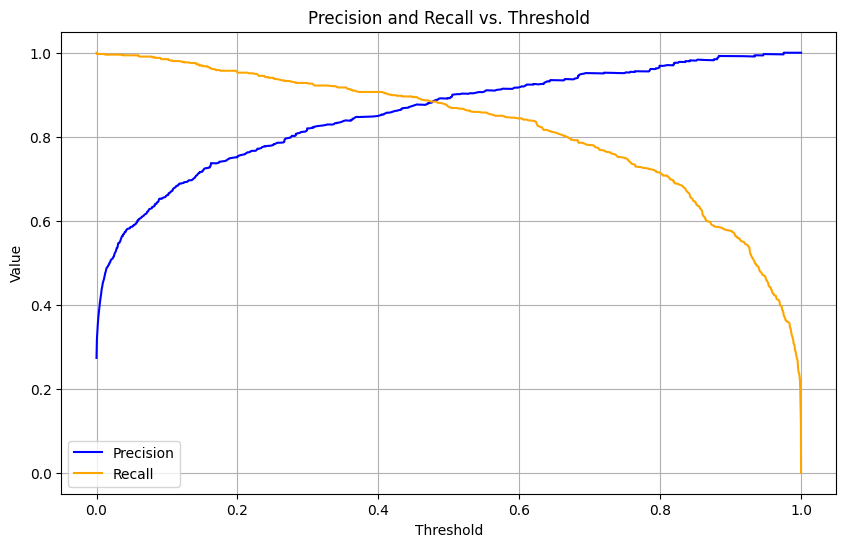

0.47661029341251543

In [6]:
# Compute precision and recall for various thresholds
precision, recall, thresholds = precision_recall_curve(y_val, y_pred)

# Plot precision and recall
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision', color='blue')
plt.plot(thresholds, recall[:-1], label='Recall', color='orange')
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Determine the threshold where precision and recall curves intersect
intersect_threshold = thresholds[np.argmin(np.abs(precision[:-1] - recall[:-1]))]
intersect_threshold



### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.12
- 0.32
- 0.52
- 0.72

In [20]:
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])

max_f1_threshold = thresholds[np.argmax(f1_scores)]
print(f"Best possible f1 threshold: {max_f1_threshold}")

# Given threshold options for Question 4
threshold_options = [0.12, 0.32, 0.52, 0.72]

f1_scores_approx = {}
for th_option in threshold_options:
    closest_threshold = thresholds[np.argmin(np.abs(thresholds - th_option))]
    f1_score_closest = f1_scores[np.where(thresholds == closest_threshold)[0][0]]
    f1_scores_approx[th_option] = f1_score_closest

# Determine the threshold option which gives the highest approximate F1 score
best_f1_threshold_approx = max(f1_scores_approx, key=f1_scores_approx.get)
best_f1_score = f1_scores_approx[best_f1_threshold_approx]
print(f"Best f1 score with given threshold: {best_f1_score}")
print(f"Best given f1 threshold: {best_f1_threshold_approx}")

Best possible f1 threshold: 0.48782275594830077
Best f1 score with given threshold: 0.8845553822152886
Best given f1 threshold: 0.52


### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?

- 0.003
- 0.030
- 0.090
- 0.140

In [25]:
# Use 5-Fold cross-validation to evaluate the model
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
auc_scores = []

# Convert full train dataset to dictionaries for one-hot encoding
full_train_dicts = df_full_train.drop(columns=['msrp', 'above_average']).to_dict(orient='records')
X_full_train = dv.transform(full_train_dicts)
y_full_train = df_full_train['above_average'].values

# Evaluate model on 5 different folds
for train_idx, val_idx in kfold.split(X_full_train):
    X_train_fold, X_val_fold = X_full_train[train_idx], X_full_train[val_idx]
    y_train_fold, y_val_fold = y_full_train[train_idx], y_full_train[val_idx]

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_fold, y_train_fold)

    y_pred_fold = model.predict_proba(X_val_fold)[:, 1]
    auc_fold = roc_auc_score(y_val_fold, y_pred_fold)

    auc_scores.append(auc_fold)

# Compute standard deviation of the scores across different folds
std_dev_auc = np.std(auc_scores)
round(std_dev_auc, 3)

0.003

### Question 6: Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.01, 0.1, 0.5, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.01
- 0.1
- 0.5
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [28]:
# List of C values to iterate over
C_values = [0.01, 0.1, 0.5, 10]

# Dictionary to store mean and std of AUC scores for each C
scores_for_C = {}

# Use 5-Fold cross-validation for each value of C
for C in C_values:
    auc_scores_c = []

    # Evaluate model on 5 different folds for the current C value
    for train_idx, val_idx in kfold.split(X_full_train):
        X_train_fold, X_val_fold = X_full_train[train_idx], X_full_train[val_idx]
        y_train_fold, y_val_fold = y_full_train[train_idx], y_full_train[val_idx]

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_fold, y_train_fold)

        y_pred_fold = model.predict_proba(X_val_fold)[:, 1]
        auc_fold = roc_auc_score(y_val_fold, y_pred_fold)

        auc_scores_c.append(auc_fold)

    # Compute mean and standard deviation of AUC scores for the current C value
    mean_auc_c = np.mean(auc_scores_c)
    std_auc_c = np.std(auc_scores_c)

    scores_for_C[C] = (mean_auc_c, std_auc_c)

# Find the best C value based on the mean AUC scores
best_C = max(scores_for_C, key=lambda k: scores_for_C[k][0])
print(scores_for_C[best_C])
best_C

(0.9808963219734256, 0.0023857679028159136)


10

### Submit the results

- Submit your results here: https://forms.gle/E7Fa3WuBw3HkPQYg6
- If your answer doesn't match options exactly, select the closest one.
- You can submit your solution multiple times. In this case, only the last submission will be used